In [2]:
%config IPCompleter.greedy=True

In [3]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import os

import nltk
from nltk.stem.snowball import SnowballStemmer

from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.optimizers import Adam, SGD

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from hyperopt import fmin, tpe, hp, Trials, STATUS_OK

In [4]:
%matplotlib inline
np.random.seed(99)
plt.style.use('ggplot')

In [5]:
train_set = fetch_20newsgroups(subset='train', shuffle=True)
test_set = fetch_20newsgroups(subset='test', shuffle=True)

In [6]:
nltk.download('snowball_data')
nltk.download('stopwords')

[nltk_data] Downloading package snowball_data to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [7]:
# create stemming based CountVectorized

class StemmedCountVectorizer(CountVectorizer):
  def build(self):
    analyzer = super(StemmedCountVectorizer, self).build_analyzer()
    return lambda text: ([stemmer.stem(word) for word in anlayzer(text)])

In [8]:
stemmer = SnowballStemmer('english', ignore_stopwords=True)
stem_count_vec = StemmedCountVectorizer(stop_words='english')

In [9]:
stem_count_vec.fit(train_set.data)

X_train = stem_count_vec.transform(train_set.data)
X_test = stem_count_vec.transform(test_set.data)

num_classes = np.max(train_set['target']) + 1

y_train = to_categorical(train_set.target, num_classes)
y_test = to_categorical(test_set.target, num_classes)

In [10]:
def plot_history(history, name):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  x = range(1, len(acc) + 1)

  plt.figure(figsize=(12, 5))
  plt.subplot(1, 2, 1)
  plt.plot(x, acc, 'blue', label='Training accuracy')
  plt.plot(x, val_acc, 'red', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(x, loss, 'blue', label='Training loss')
  plt.plot(x, val_loss, 'red', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()
  plt.show()

In [11]:
def train_callback(params):
  print(f'Training for {params} parameters')

  input_dim = X_train.shape[1]
  output_dim = y_train.shape[1]

  model = Sequential()
  model.add(layers.Dense(
      params['dense_layer_neurons'],
      input_dim=input_dim,
      activation='relu'
  ))

  if params['use_deeper_network']:
    model.add(layers.Dense(
        32,
        activation='relu'
    ))

  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(output_dim, activation='softmax'))

  model.compile(
      optimizer=params['optimizer'],
      loss='categorical_crossentropy',
      metrics=['accuracy']
  )

  history = model.fit(
      X_train,
      y_train,
      epochs=params['epochs'],
      verbose=2,
      validation_data=(X_test, y_test),
      batch_size=params['batch_size']
  )

  val_accuracy = history.history['val_accuracy'][-1]

  return {
      'loss': -val_accuracy,
      'status': STATUS_OK,
      'model': model,
      'history': history
  }

In [12]:
params = {
    "dense_layer_neurons": hp.choice("dense_layer_neurons", [64, 96, 128]),
    "optimizer": hp.choice("optimizer", [Adam(), SGD()]),
    "batch_size": hp.choice("batch_size", [10, 32]),
    "epochs": hp.choice("epochs", [25, 50]),
    "use_deeper_network": hp.choice("use_deeper_network", [True, False])
}

In [13]:

trials = Trials()

max_evals = 3 * 2 * 2 * 2 * 2

In [14]:
best = fmin(
    fn=train_callback,
    space=params,
    algo=tpe.suggest,
    trials=trials,
    max_evals=max_evals
)

Strumieniowane dane wyjściowe obcięte do 5000 ostatnich wierszy.
354/354 - 1s - loss: 0.1057 - accuracy: 0.9879 - val_loss: 0.8658 - val_accuracy: 0.8250

Epoch 50/50
354/354 - 1s - loss: 0.1041 - accuracy: 0.9884 - val_loss: 0.8722 - val_accuracy: 0.8249

Training for {'batch_size': 10, 'dense_layer_neurons': 128, 'epochs': 25, 'optimizer': <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7f8b1cb2db70>, 'use_deeper_network': True} parameters
Epoch 1/25
1132/1132 - 6s - loss: 1.7421 - accuracy: 0.5205 - val_loss: 0.8713 - val_accuracy: 0.7894

Epoch 2/25
1132/1132 - 6s - loss: 0.7212 - accuracy: 0.8136 - val_loss: 0.7815 - val_accuracy: 0.8088

Epoch 3/25
1132/1132 - 6s - loss: 0.4149 - accuracy: 0.8838 - val_loss: 0.7750 - val_accuracy: 0.8208

Epoch 4/25
1132/1132 - 5s - loss: 0.2737 - accuracy: 0.9160 - val_loss: 0.8132 - val_accuracy: 0.8315

Epoch 5/25
1132/1132 - 6s - loss: 0.2236 - accuracy: 0.9334 - val_loss: 0.8972 - val_accuracy: 0.8267

Epoch 6/25
1132/1132 - 6s -

INFO:tensorflow:Assets written to: simple_model.hd5/assets


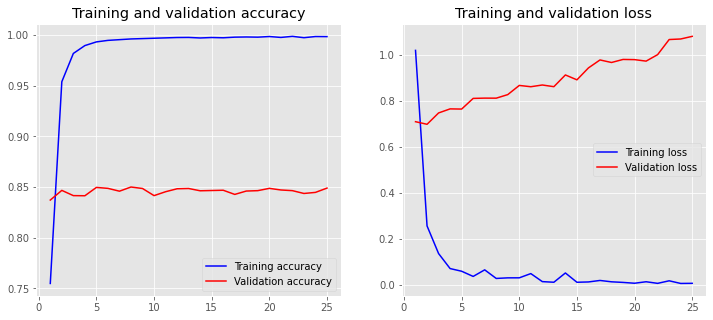

In [32]:
best_model = trials.best_trial['result']['model']
history = trials.best_trial['result']['history']

best_model.save('simple_model.hd5')
plot_history(history, "simple_model")

In [19]:
import pdb

In [51]:
def test_model(model):
  correct_predictions = 0
  num_of_samples = len(y_test)


  for x, y in zip(X_test, y_test):
    prediction = model.predict(x)

    if prediction.argmax() == y.argmax():
      correct_predictions += 1
    
  return correct_predictions / num_of_samples

In [52]:
loaded_model = load_model('simple_model.hd5')
results = test_model(loaded_model)
print(results)

0.8490440785979819
